In [25]:
# libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimizer
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

In [26]:
torch.manual_seed(12)

device = ('cuda' if torch.cuda.is_available else 'cpu')

TRAIN_DATA_PATH = 'Datasets/fashion_mnist/train.csv'
TEST_DATA_PATH = 'Datasets/fashion_mnist/test.csv'

train_df = pd.read_csv(TRAIN_DATA_PATH)
test_df = pd.read_csv(TEST_DATA_PATH)

In [15]:
train_df.shape

(60000, 785)

In [27]:
test_df.shape

(10000, 785)

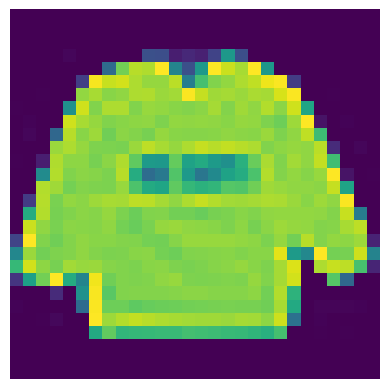

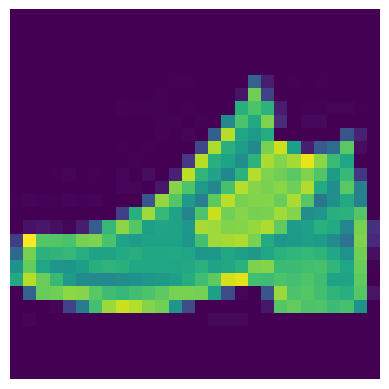

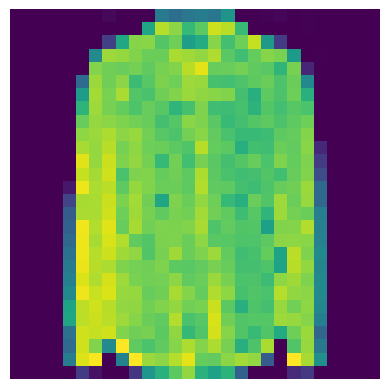

In [28]:
# show first 3 images
for i in range(3):
    img = train_df.iloc[i, 1:].values.reshape(28,28)
    plt.imshow(img) 
    plt.axis('off')
    plt.show()

In [29]:
X = train_df.iloc[:,1:] # rest pixel values
y = train_df.iloc[:, 0] # label is in the first

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=12)

X_train = X_train / 255.0
X_test = X_test / 255.0

print(X_train.shape)
print(y_train.shape)

(48000, 784)
(48000,)


In [30]:
class dataset(Dataset):

    def __init__(self, features, labels):

        features = np.array(features) # idk why i have to do this before convt to torch tensor
        labels = np.array(labels)
        
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
        
    def __len__(self):
        
        return self.features.shape[0]

    def __getitem__(self, idx):
        
        return self.features[idx], self.labels[idx]

In [31]:
train_dataset = dataset(X_train, y_train)
test_dataset = dataset(X_test, y_test)

In [32]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [47]:
class NeuralNet(nn.Module):

    def __init__(self, in_features, out_features, lr):

        super().__init__()

        self.Linear1 = nn.Linear(in_features=in_features, out_features=128)
        self.Linear2 = nn.Linear(in_features=128, out_features=64)
        self.Linear3 = nn.Linear(in_features=64, out_features=out_features)

        self.Dropout1 = nn.Dropout(p=0.3)
        self.Dropout2 = nn.Dropout(p=0.3)

        self.BatchNorm1 = nn.BatchNorm1d(128)
        self.BatchNorm2 = nn.BatchNorm1d(64)

        self.optimizer = optimizer.Adam(self.parameters(), lr=lr)
        self.loss_function = nn.CrossEntropyLoss()

    def forward(self, x):

        x = self.Linear1(x)
        x = self.BatchNorm1(x)
        x = self.Dropout1(F.relu(x))
        
        x = self.Linear2(x)
        x = self.BatchNorm2(x)
        x = self.Dropout2(F.relu(x))
        
        x = self.Linear3(x)
        x = F.softmax(x)

        return x

    def compute_loss(self, y_pred, y_true):

        return self.loss_function(y_pred, y_true.long())
        
neuralNet = NeuralNet(in_features=X_train.shape[1], out_features=10, lr=1e-4)

In [51]:
EPOCHS = 100

for epoch in range(EPOCHS):

    total_epoch_loss = 0.0
    
    for batch_features, batch_labels in train_loader:

        y_pred = neuralNet.forward(batch_features)
        
        loss = neuralNet.compute_loss(y_pred, batch_labels)
        neuralNet.optimizer.zero_grad()
        loss.backward()
        neuralNet.optimizer.step()

        total_epoch_loss += loss.item()

    avg_loss = total_epoch_loss/len(train_loader)

    print(f" Average loss for epoch {epoch+1}: {avg_loss}")
        

/var/folders/d7/w273k3tx6q70_9wxncth_6d00000gn/T/ipykernel_22218/3072692335.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


 Average loss for epoch 1: 1.550549336830775
 Average loss for epoch 2: 1.5465018142064413
 Average loss for epoch 3: 1.5438213857809702
 Average loss for epoch 4: 1.5424014971256257
 Average loss for epoch 5: 1.5406749683221181
 Average loss for epoch 6: 1.540378675619761
 Average loss for epoch 7: 1.538921307404836
 Average loss for epoch 8: 1.5374060486157735
 Average loss for epoch 9: 1.5371114060878754
 Average loss for epoch 10: 1.5366278981367747
 Average loss for epoch 11: 1.5345417443116507
 Average loss for epoch 12: 1.5336560346285502
 Average loss for epoch 13: 1.5334675705432892
 Average loss for epoch 14: 1.5338875125249227
 Average loss for epoch 15: 1.5326154900391897
 Average loss for epoch 16: 1.5324968674977621
 Average loss for epoch 17: 1.531016255458196
 Average loss for epoch 18: 1.530894359032313
 Average loss for epoch 19: 1.529555219888687
 Average loss for epoch 20: 1.5303245294888814
 Average loss for epoch 21: 1.529352288722992
 Average loss for epoch 22: 1

In [52]:
neuralNet.eval()

NeuralNet(
  (Linear1): Linear(in_features=784, out_features=128, bias=True)
  (Linear2): Linear(in_features=128, out_features=64, bias=True)
  (Linear3): Linear(in_features=64, out_features=10, bias=True)
  (Dropout1): Dropout(p=0.3, inplace=False)
  (Dropout2): Dropout(p=0.3, inplace=False)
  (BatchNorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BatchNorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (loss_function): CrossEntropyLoss()
)

In [53]:
total = 0
correct = 0

with torch.no_grad():

    for batch_features, batch_labels in test_loader:

        outputs = neuralNet.forward(batch_features)
        _, predicted = torch.max(outputs, 1)

        total += batch_features.shape[0]
        correct += (predicted == batch_labels).sum().item()
    
print(100*correct/total) # accuracy

/var/folders/d7/w273k3tx6q70_9wxncth_6d00000gn/T/ipykernel_22218/3072692335.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


88.76666666666667
